<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model Interpretation using RISE for timeseries data
This notebook shows how to apply the RISE explainability method on a model trained to classify timeseries data. Two examples are included here:
- Verify RISE for timeseries with a simple "expert" model
- Demonstrate RISE with a pretrained weather forecast (onnx) model

It visualizes the relevance attributions for each segmentation of timeseries by displaying them on top of the timeseries.<br>

[RISE](http://bmvc2018.org/contents/papers/1064.pdf) is short for Randomized Input Sampling for Explanation of Black-box Models. It estimates the relevance empirically by probing the model with randomly masked versions of the input image to obtain the corresponding outputs.<br>

#### Colab Setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
    # install dianna
    !python3 -m pip install dianna[notebooks]

### Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from dianna import visualization
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import onnx
import onnxruntime as ort
import dianna

np.random.seed(0)
root_dir = Path(dianna.__file__).parent

#### 1 - Create a mini dataset with extremes for verification
To demonstrate the skill of RISE for timeseries model explanation, we "make up" a weather dataset (timeseries) with extrem hot days and cold days.

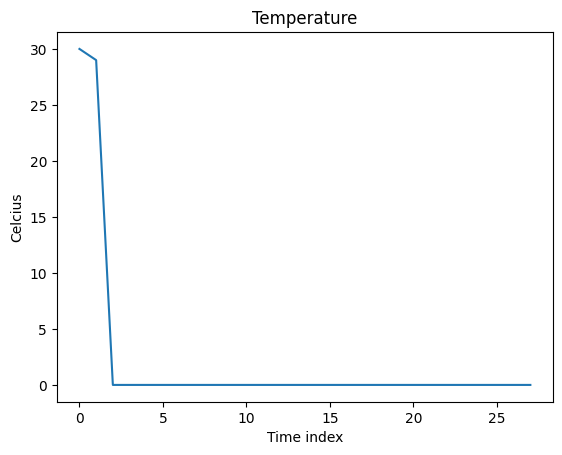

In [2]:
# make up a weather dataset with extrems
cold_with_2_hot_days = np.expand_dims(np.array([30, 29] + list(np.zeros(26))) , axis=1)
data_extreme = cold_with_2_hot_days
fig = plt.figure()
plt.plot(data_extreme)
plt.xlabel("Time index")
plt.ylabel("Celcius")
plt.title("Temperature")
plt.show()

#### 2 - Define an "expert" model to verify RISE for timeseries
We can define an 'expert' model to test RISE. This expert model decides it's summer if the mean temp is above the threshold, and winter in other cases.

In [3]:
# We define a threshold for the model to make decisions
# The label is ["summer", "winter"]
threshold = 14

def run_expert_model(data):
    is_summer = np.mean(np.mean(data, axis=1), axis=1) > threshold
    number_of_classes = 2
    number_of_instances = data.shape[0]
    result = np.zeros((number_of_instances ,number_of_classes))
    result[is_summer] = [1.0, 0.0]
    result[~is_summer] = [0.0, 1.0]
    return result

#### 3 - Compute and visualize the relevance scores
In this section we compute the relevance scores for each segment of timeseries using RISE and visualize them on the original timeseries.

RISE masks random portions of the input timseries based on given segmentations and passes the masked timeseries through the model — the masked portion that decreases accuracy the most is the most “important” portion.<br>

To call the explainer and generate relevance scores map, the user need to specifiy the number of masks being randomly generated (`n_masks`), the resolution of features in masks (`feature_res`) and for each mask and each feature in the image, the probability of being kept unmasked (`p_keep`).<br>

Also, we need to define the approach for masking (`mask_type`). Since our data is highly skewed, here we make the masked data to be the "threshold" value instead of the mean.

In [4]:
# we use the threshold to mask the data
def input_train_mean(_data):
    return threshold

In [5]:
# call the explainer
explanation = dianna.explain_timeseries(run_expert_model, input_timeseries=data_extreme,
                                        method='rise', labels=[0,1], p_keep=0.1,
                                        n_masks=10000, mask_type=input_train_mean)

Explaining: 100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 26671.14it/s]


Now we can visualize the relevance scores on top of the displayed timeseries using the visualization tool in dianna.

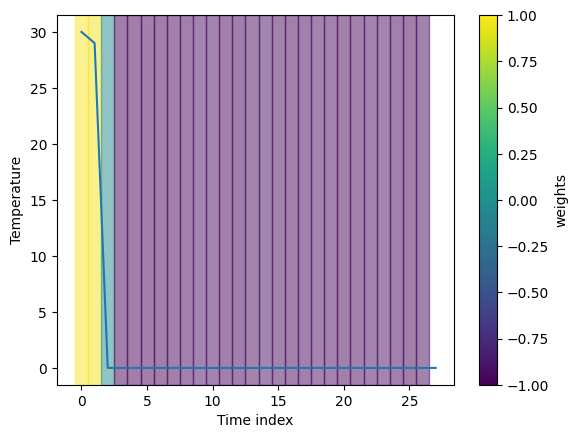

In [6]:
# Normalize the explanation scores for the purpose of visualization
def normalize(data):
    """Squash all values into [-1,1] range."""
    zero_to_one = (data - np.min(data)) / (np.max(data) - np.min(data))
    return 2*zero_to_one -1

heatmap_channel = normalize(explanation[0])
segments = []
for i in range(len(heatmap_channel) - 1):
    segments.append({
        'index': i,
        'start': i - 0.5,
        'stop': i + 0.5,
        'weight': heatmap_channel[i]})
fig, _ = visualization.plot_timeseries(range(len(heatmap_channel)), data_extreme,
                              segments, x_label="Time index", y_label="Temperature")

Here we plot the explanation for the classification of summer. The results are consistent with our expectation as it marks all hot days in the timeseries. <br>

Now let's try out RISE with a weather prediction dataset from real life. <br>
Here is the doi to this dataset: <br>
10.5281/zenodo.4770936

#### 4 - Loading the weather prediction dataset
Downloading the weather prediction dataset from zenodo.

In [7]:
fname = "weather_prediction_dataset.csv"
if os.path.isfile(fname):
    data = pd.read_csv(fname)
else:
    data = pd.read_csv(f"https://zenodo.org/record/7525955/files/{fname}?download=1")
data.describe()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
count,3.654000e+03,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,...,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2.004568e+07,6.520799,5.418446,0.745107,1.017876,1.330380,0.234849,4.661193,11.022797,6.989135,...,5.104215,11.470635,3.677258,0.781872,1.016639,1.369787,0.186100,12.205802,7.860536,16.551779
std,2.874287e+04,3.450083,2.325497,0.107788,0.007962,0.935348,0.536267,4.330112,7.414754,6.653356,...,7.250744,8.950217,1.519866,0.115572,0.018885,0.926472,0.422151,6.467155,5.692256,7.714924
min,2.000010e+07,1.000000,0.000000,0.380000,0.985600,0.050000,0.000000,0.000000,-9.300000,-16.000000,...,-19.700000,-14.500000,0.700000,0.330000,0.000300,0.050000,0.000000,-6.200000,-13.000000,-3.100000
25%,2.002070e+07,4.000000,4.000000,0.670000,1.013300,0.530000,0.000000,0.500000,5.300000,2.000000,...,0.000000,4.100000,2.600000,0.700000,1.012100,0.550000,0.000000,7.600000,3.700000,10.800000
50%,2.004567e+07,7.000000,6.000000,0.760000,1.017700,1.110000,0.000000,3.600000,11.400000,7.300000,...,5.000000,11.000000,3.400000,0.800000,1.017300,1.235000,0.000000,12.300000,8.300000,16.600000
75%,2.007070e+07,10.000000,7.000000,0.830000,1.022700,2.060000,0.210000,8.000000,16.900000,12.400000,...,11.200000,19.000000,4.600000,0.870000,1.022200,2.090000,0.160000,17.200000,12.300000,22.400000
max,2.010010e+07,12.000000,8.000000,0.980000,1.040800,3.550000,7.570000,15.300000,29.000000,20.800000,...,21.200000,32.900000,10.800000,1.000000,1.041400,3.560000,6.200000,31.200000,22.600000,39.800000


Given how the classification model is trained, we prepare the testing data for prediction. <br>
To make it simpler, we only choose one location and make it a binary classification task, to determine whether it is summer or winter.

In [8]:
# select only data from one location (De Bilt)
columns = [col for col in data.columns if col.startswith('DE_BILT') and col.endswith('temp_max')]
data_debilt = data[columns]
data_debilt.describe()

,DE_BILT_temp_max
count,3654.000000
mean,14.798604
std,7.210740
min,-4.700000
25%,9.200000
50%,14.900000
75%,20.200000
max,35.700000


In [9]:
# find where the month changes
idx = np.where(np.diff(data['MONTH']) != 0)[0]
# idx contains the index of the last day of each month, except for the last month.
# of the last month only a single day is recorded, so we discard it.

nmonth = len(idx)
# add start of first month
idx = np.insert(idx, 0, 0)
ncol = len(columns)
# create single object containing each timeseries
# for simplicity we truncate each timeseries to the same length, i.e. 28 days
nday = 28
data_ts = np.zeros((nmonth, nday, ncol))
for m in range(nmonth):
    data_ts[m] = data_debilt[idx[m]:idx[m+1]][:28]
    
print(data_ts.shape)

(120, 28, 1)


We label the data based on the seasons. <br>
To simplify the problem, we make it a binary classification task and only select summer and winter. <br>

In [10]:
# the labels are based on the month of each timeseries, in range 1 to 12
months = (np.arange(nmonth) + data['MONTH'][0] - 1) % 12 + 1

# one class per meteorological season
labels = np.zeros_like(months, dtype=int)
summer = (6 <= months) & (months <= 8)   # jun - aug
winter = (months <= 2) | (months == 12)  # dec - feb

labels[summer] = 0
labels[winter] = 1

target = pd.get_dummies(labels[summer + winter])

classes = ['summer', 'winter']
nclass = len(classes)

data_ts = data_ts[summer + winter]
data_ts.shape

(60, 28, 1)

Train/test split

In [11]:
data_trainval, data_test, target_trainval, target_test = train_test_split(data_ts, target, stratify=target, random_state=0, test_size=.12)
data_train, data_val, target_train, target_val = train_test_split(data_trainval, target_trainval, stratify=target_trainval, random_state=0, test_size=.12)
print(data_train.shape, data_val.shape, data_test.shape)

(45, 28, 1) (7, 28, 1) (8, 28, 1)


Load ONNX model and create a ONNX model runner.

In [12]:
# onnx model available on surf drive
# path to ONNX model
onnx_file = Path(root_dir, 'models', 'season_prediction_model_temp_max_binary.onnx')

# verify the ONNX model is valid
onnx_model = onnx.load(onnx_file)
onnx.checker.check_model(onnx_model)

def run_model(data):
    # model must receive input in the order of [batch, timeseries, channels]
    # data = data.transpose([0,2,1])
    # get ONNX predictions
    sess = ort.InferenceSession(onnx_file)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    onnx_input = {input_name: data.astype(np.float32)}
    pred_onnx = sess.run([output_name], onnx_input)[0]
    
    return pred_onnx

Select an instance to explain and check the prediction with the model.

In [13]:
idx = 6 # explained instance
data_instance = data_test[idx][np.newaxis, ...]
# precheck ONNX predictions
pred_onnx = run_model(data_instance)
pred_class = classes[np.argmax(pred_onnx)]
print("The predicted class is:", pred_class)
print("The actual class is:", classes[np.argmax(target_test.iloc[idx])])

The predicted class is: winter
The actual class is: winter


#### 5 - Compute and visualize the relevance scores
In this section we compute the relevance scores for each segment of timeseries using RISE and visualize them on the original timeseries.

In [14]:
# call the explainer
explanation = dianna.explain_timeseries(run_model, input_timeseries=data_instance[0],
                                        method='rise', labels=[0,1], p_keep=0.1,
                                        n_masks=10000)

Explaining: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 214.61it/s]


Now we can visualize the relevance scores on top of the displayed timeseries using the visualization tool in dianna.

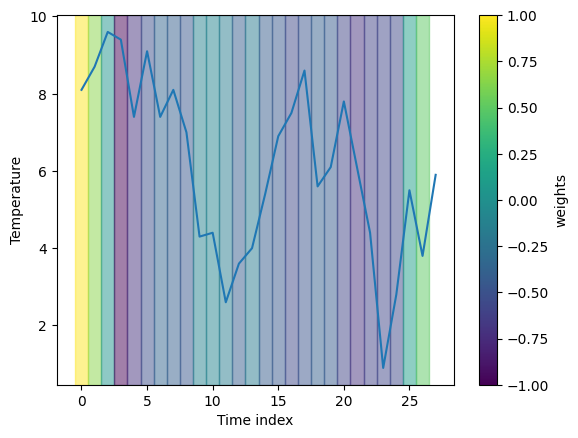

In [15]:
heatmap_channel = normalize(explanation[np.argmax(pred_onnx)])
segments = []
for i in range(len(heatmap_channel) - 1):
    segments.append({
        'index': i,
        'start': i - 0.5,
        'stop': i + 0.5,
        'weight': heatmap_channel[i]})
fig, _ = visualization.plot_timeseries(range(len(heatmap_channel)), data_instance[0],
                              segments, x_label="Time index", y_label="Temperature")

#### 6 - Conclusions
The relevance scores are generated by passing multiple randomly masked inputs to the black-box model and averaging their segment-wise relevances. The idea behind this is that whenever a mask preserves important parts of the timeseries it gets higher score. <br>

The first example with a designed timeseries and an expert model demonstrates that RISE is able to identify the important segments for the classification in a simplified case.

The second example shows that RISE for timeseries also runs on real timeseries data. The explanation is, however, hard to interpret in this case. This could be due to an suboptimally trained model, unsuitable masking strategy or unsuitable mask generation.
